In [1]:
'''
Example 1 :
Debutanizer system
'''

import numpy as np
import pandas as pd
from scipy import signal, optimize
import matplotlib.pyplot as plt

# Parameters
nu = 3  # Number of manipulated inputs
ny = 2  # Number of controlled outputs
T = 1  # Sampling time (min)
n = 300  # Stabilizing horizon
p = 30  # Output prediction horizon
m = 3  # Control horizon
nsim = 500  # Simulation time in sampling periods

# Initial input and output values
u0 = np.array([700, 6.2, 0])
y0 = np.array([2.5, 0.7])

# Input and output constraints
umax = np.array([950, 9.0, 1e3])
umin = np.array([400, 3.0, -1e3])
dumax = np.array([10, 0.5, 1e-4])
ymax = np.array([2.8, 0.75])
ymin = np.array([2.0, 0.65])

# Weights of the control layer
q = np.array([10000, 10000]) # Output weights
r = np.array([100, 100, 1])  # Input weights

# Weights of the economic layer
py = np.array([0, 0])       # Output weights
pu = np.array([0, 1, 0])    # Input weights
peps = np.array([1e5, 1e5]) # Penalty weights
ru = np.array([1, 1, 0])    # Input optimization weights


G11 = signal.dlti([-1.9973e-3, -1.3105e-4],
                  [1, -8.3071e-1, -5.4544e-1, 5.1700e-1, 0],
                  dt=T)
G12 = signal.dlti([1.9486e-2 / 24, 4.6325e-2 / 24],
                  [1, -1.5119, 4.3596e-1, 8.2888e-2, 0, 0, 0, 0, 0, 0, 0],
                  dt=T)
G13 = signal.dlti(
    [-1.5789e-4, -8.3160e-5],
    [1, -6.9794e-1, -1.8196e-1, -9.3550e-2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    dt=T)

G21 = signal.dlti([9.2722e-5, 3.1602e-5],
                  [1, -1.1613, -7.5733e-2, 3.7749e-1, 0, 0, 0, 0],
                  dt=T)

G22 = signal.dlti([-4.2379e-2 / 24],
                  [1, -1.3953, 2.5570e-1, 1.5459e-1, 0, 0, 0, 0, 0, 0, 0],
                  dt=T)

G23 = signal.dlti([6.9654e-6, 8.6757e-6],
                  [1, -8.8584e-1, 0, 0, 0, 0, 0, 0, 0, 0],
                  dt=T)

# Create a 2D list of transfer functions
Gm = [[G11, G12, G13],
      [G21, G22, G23]]

#TODO: when simulating closed loop, use a slightly different system to simulate modelling imperfections
Gp = Gm  # System = Model

def simulate(u, Gm, tp, ny, nu, y0):
    # Initialize the output array to hold the simulation results
    y = np.zeros((ny, len(tp)))

    # Loop through each manipulated input
    for i in range(nu):
        # And for each controlled output
        for j in range(ny):
            # Extract the control signal for the current input
            u_i = u[i, :]
            # Simulate the system response for the current input-output pair
            t_out, y_out = signal.dlsim(Gm[j][i], u_i, t=tp)
            # Flatten the output for easier handling
            y_out = y_out.flatten()

            # For the first step, set the initial condition by adding y0
            if i == 0 and j == 0:  # Do this once at the start of the simulation
                y[:, 0] = y0

            # Update the output with the relative change
            # Since y_out represents the system's response (change), we add it to the initial state
            # This ensures each output is adjusted relative to its starting point (y0)
            for k in range(1, len(tp)):  # Start from 1 since the initial state is already set
                y[j, k] += y_out[k] - y_out[0]  # Adjust the output based on the change from the initial response

    return y

tsim = np.linspace(0, nsim*T, nsim+1)  # Prediction Time vector
u_sim = np.tile(u0, p+1)
y_sim = 

def control_objective(u, *args):
    ''' Control objective function '''
    Gm, ymin, ymax, q, r, tp, ny, nu, y0 = args
    J = 0
    u = u.reshape((nu, -1))
    u[:, 0] = u0
    yp = simulate(u, Gm, tp, ny, nu, y0)

    ymin = np.asarray(ymin).reshape(-1, 1)
    ymax = np.asarray(ymax).reshape(-1, 1)
    q = np.asarray(q).reshape(-1, 1)

    assert yp.ndim == 2 and yp.shape[0] == ymin.shape[0]

    error = np.sum(q * ((yp < ymin) * (ymin - yp) + (yp > ymax) * (yp - ymax)))
    J += error
    # delta_u = np.diff(u, axis=1)
    # J += np.sum(r * np.sum(delta_u**2, axis=1))

    return J

# Optimization setup
tp = np.linspace(0, p*T, p+1)  # Prediction Time vector
u0_flattened = np.tile(u0, p+1)  # Initial guess for the input sequence
# Define bounds for u
# umin_repeated = np.repeat(umin, p+1)
# umax_repeated = np.repeat(umax, p+1)
# bounds = [(low, high) for low, high in zip(umin_repeated, umax_repeated)]

# Optimization call
result = optimize.minimize(control_objective,
                           u0_flattened,
                           args=(Gm, ymin, ymax, q, r, tp, ny, nu, y0),
                           method='SLSQP')


# Process optimization results
if result.success:
    u_optimal = result.x.reshape(nu, -1)
    print('Optimal control sequence found.')
else:
    print('Optimization failed.')

# Simulate the system with the optimal control inputs
yp_optimal = simulate(u_optimal, Gm, tp, ny, nu, y0)



#TODO: use control horizon on optimization
#TODO: use bounds of umax, umin
#TODO: use constrain of dumax for the optimization

#TODO: make the implementation of the control layer
# get the optimal u and use it as new u0 for a simulation
# to get the response of the system, make it for time = nsim
# on each step, get the new y and use it as new y0 for the next control calculation

Optimal control sequence found.


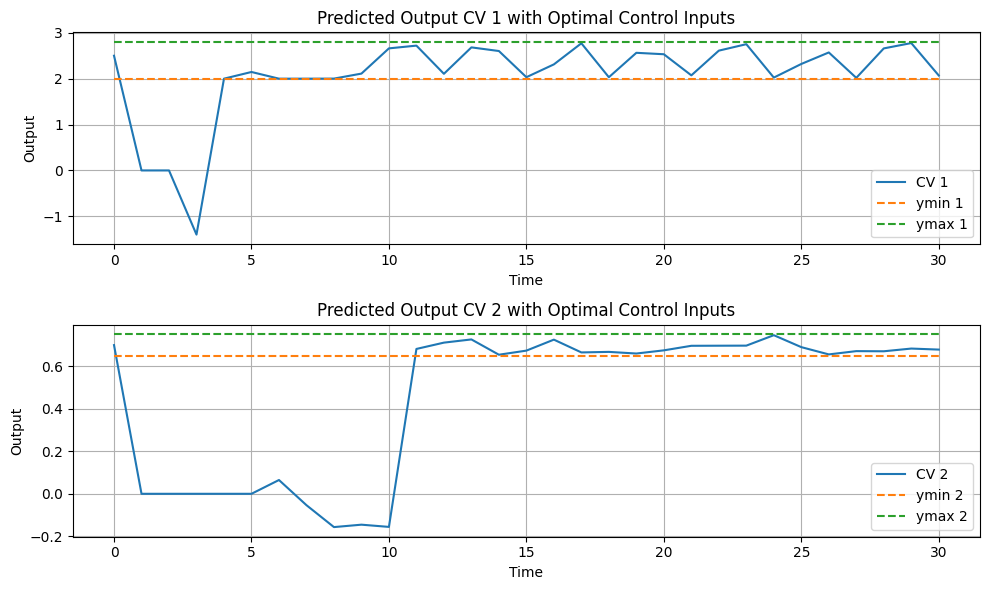

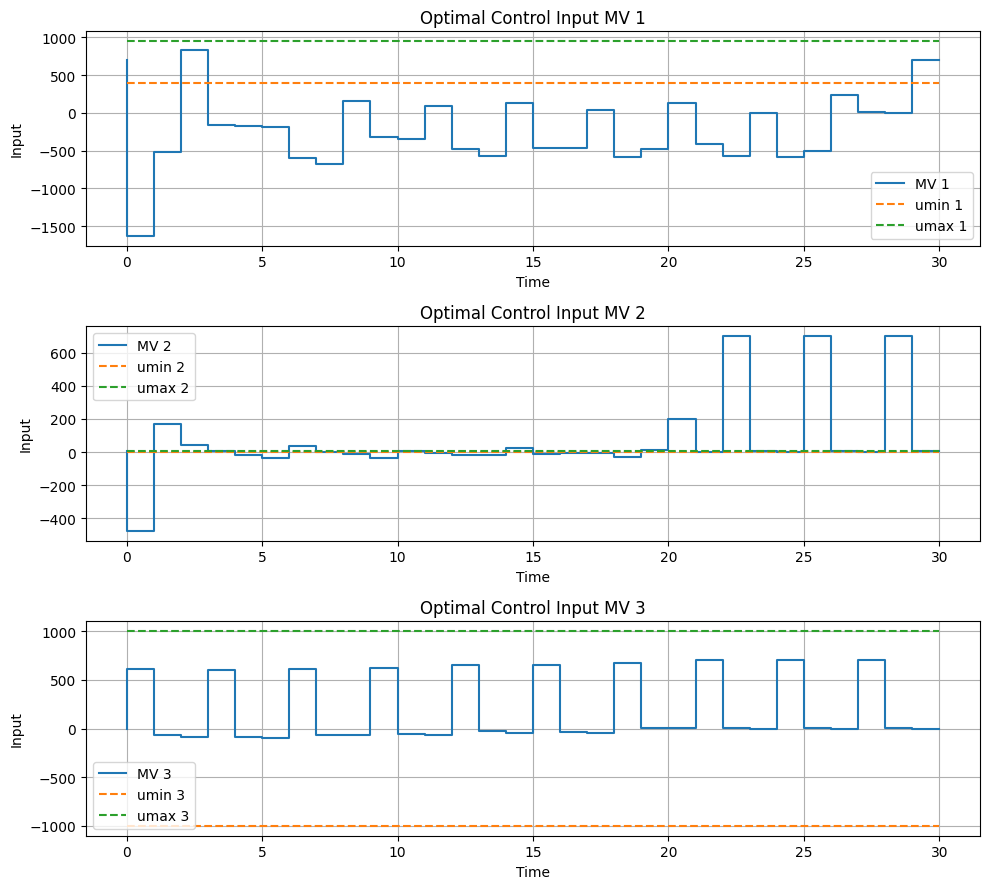

In [2]:


# Create subplots for CVs
fig1, axs1 = plt.subplots(ny, figsize=(10, ny*3))
for i in range(ny):
    axs1[i].plot(tp, yp_optimal[i], label=f'CV {i+1}')
    axs1[i].plot(tp, np.full_like(tp, ymin[i]), '--', label=f'ymin {i+1}')
    axs1[i].plot(tp, np.full_like(tp, ymax[i]), '--', label=f'ymax {i+1}')
    axs1[i].set_title(f'Predicted Output CV {i+1} with Optimal Control Inputs')
    axs1[i].set_xlabel('Time')
    axs1[i].set_ylabel('Output')
    axs1[i].grid(True)
    axs1[i].legend()

plt.tight_layout()
plt.show()

# Create subplots for MVs
fig2, axs2 = plt.subplots(nu, figsize=(10, nu*3))
for i in range(nu):
    axs2[i].step(tp, u_optimal[i], label=f'MV {i+1}')
    axs2[i].plot(tp, np.full_like(tp, umin[i]), '--', label=f'umin {i+1}')
    axs2[i].plot(tp, np.full_like(tp, umax[i]), '--', label=f'umax {i+1}')
    axs2[i].set_title(f'Optimal Control Input MV {i+1}')
    axs2[i].set_xlabel('Time')
    axs2[i].set_ylabel('Input')
    axs2[i].grid(True)
    axs2[i].legend()

plt.tight_layout()
plt.show()